<a href="https://colab.research.google.com/github/ronghuwz/CNN-Fashion-MNIST-Classifying/blob/main/CNN-Fashion-MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks for Classifying Fashion-MNIST Dataset using Ignite


In this notebook, we will be doing classification of images using Convolutional Neural Networks

We will be using the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) Fashion-MNIST is a set of 28x28 grayscale images of clothes.

![Fashion MNIST dataset](https://github.com/abdulelahsm/ignite/blob/update-tutorials/examples/notebooks/assets/fashion-mnist.png?raw=1)


In [ ]:
!pip install pytorch-ignite

You should consider upgrading via the 'c:\users\jingh\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


### Importing libraries

General Data-Science Libraries like numpy, matplotlib and seaborn

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

In [ ]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping

In [ ]:
# transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.FashionMNIST('./data', download=True, train=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
validationset = datasets.FashionMNIST('./data', download=True, train=False, transform=transform)
val_loader = DataLoader(validationset, batch_size=64, shuffle=True)

### Explore Data

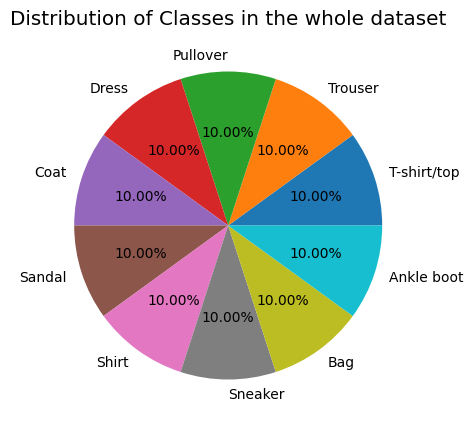

In [ ]:
fig = plt.figure(figsize=(5,5))

plt.pie(trainset.targets.bincount().numpy(),
        labels=dict(zip(trainset.classes,range(10))),
        autopct='%1.2f%%')

plt.title('Distribution of Classes in the whole dataset',size='x-large')
plt.show()

In [ ]:
a = next(iter(train_loader))
a[0].size()


torch.Size([64, 1, 28, 28])

In [ ]:
len(trainset)

60000

### Visualize data

In [ ]:
demo_loader = torch.utils.data.DataLoader(trainset, batch_size=32)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([32, 1, 28, 28]) torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  Ankle Boot, T-shirt/Top, T-shirt/Top, Dress, T-shirt/Top, Pullover, Sneaker, Pullover, Sandal, Sandal, T-shirt/Top, Ankle Boot, Sandal, Sandal, Sneaker, Ankle Boot, Trouser, T-shirt/Top, Shirt, Coat, Dress, Trouser, Coat, Bag, Coat, Dress, T-shirt/Top, Pullover, Coat, Coat, Sandal, Dress, 

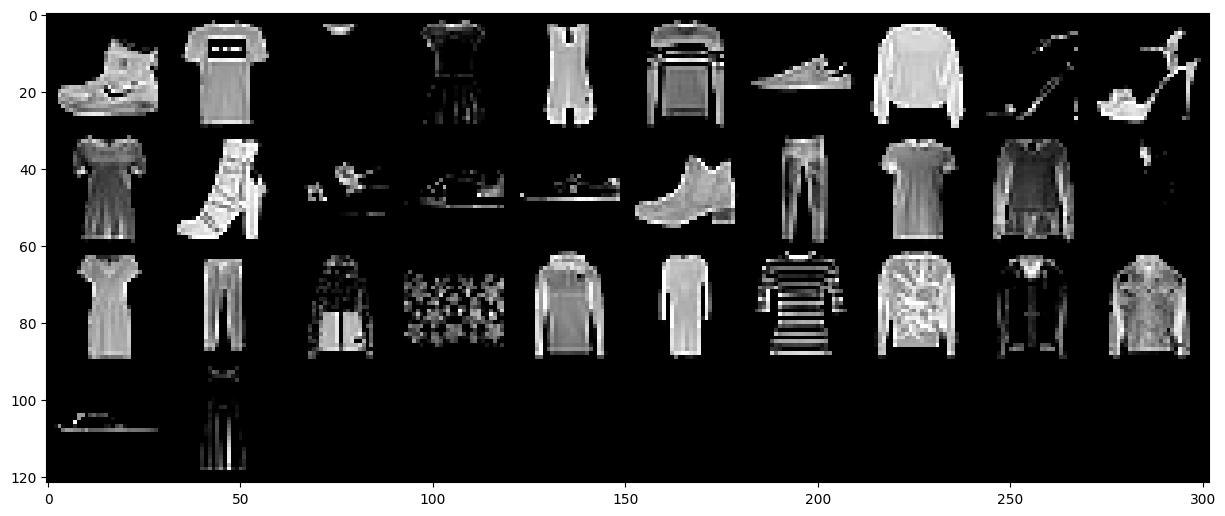

In [ ]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat",
                 5: "Sandal",
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

grid = torchvision.utils.make_grid(images, nrow=10) #nrow is number of elements in a single row

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))   # transpose to (h,w,c) instead of (c,h,w)
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")

### Build CNN Model

In [ ]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        self.convlayer1 = nn.Sequential(
            nn.Conv2d(1, 32, 3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.convlayer2 = nn.Sequential(
            nn.Conv2d(32,64,3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Linear(64*6*6,600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(600, 120)
        self.fc3 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.convlayer1(x)
        x = self.convlayer2(x)
        x = x.view(-1,64*6*6)
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return F.log_softmax(x,dim=1)

### Creating Model, Optimizer and Loss

In [ ]:
# creating model,and defining optimizer and loss
model = CNN()
# moving model to gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

### Training and Evaluating using Ignite

In [ ]:
# defining the number of epochs
epochs = 12
# creating trainer,evaluator
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
metrics = {
    'accuracy':Accuracy(),
    'nll':Loss(criterion),
    'cm':ConfusionMatrix(num_classes=10)
}
train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
last_epoch = []

### Metrics - RunningAverage


In [ ]:
#Attach a metric of RunningAverage to track a running average of the scalar loss output for each batch.
RunningAverage(output_transform=lambda x: x).attach(trainer, 'loss')

### EarlyStopping - Tracking Validation Loss


In [ ]:
#Setup a EarlyStopping handler for this training process.
def score_function(engine):
    val_loss = engine.state.metrics['nll']
    return -val_loss

handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)
val_evaluator.add_event_handler(Events.COMPLETED, handler)

### Attaching Custom Functions to Engine at specific Events


In [ ]:
# functions to print the results of the evaluator run on a dataset.

# Method 1: using a decorator,which will be attached to the trainer and called at the end of each epoch.
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['nll']
    last_epoch.append(0)
    training_history['accuracy'].append(accuracy)
    training_history['loss'].append(loss)
    print("Training Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, accuracy, loss))

# Method 2: using the add_event_handler method of trainer
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['nll']
    validation_history['accuracy'].append(accuracy)
    validation_history['loss'].append(loss)
    print("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, accuracy, loss))

trainer.add_event_handler(Events.EPOCH_COMPLETED, log_validation_results)

### Define Confusion Matrix

In [ ]:
#Confusion matrix gives us a better idea of what our classification model is getting right and what types of errors it is making.
@trainer.on(Events.COMPLETED)
def log_confusion_matrix(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    cm = metrics['cm']
    cm = cm.numpy()
    cm = cm.astype(int)
    classes = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
    fig, ax = plt.subplots(figsize=(10,10))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,fmt="d")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(classes,rotation=90)
    ax.yaxis.set_ticklabels(classes,rotation=0)

### Setup ModelCheckpoint


In [ ]:
#if something goes wrong during training, a model checkpoint can be helpful to restart training from the point of failure.
checkpointer = ModelCheckpoint('./saved_models', 'fashionMNIST', n_saved=2, create_dir=True, save_as_state_dict=True, require_empty=False)
trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {'fashionMNIST': model})

### Run Engine



c:\users\jingh\appdata\local\programs\python\python38\lib\site-packages\torch\nn\functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Training Results - Epoch: 1  Avg accuracy: 87.39 Avg loss: 0.34
Validation Results - Epoch: 1  Avg accuracy: 85.85 Avg loss: 0.38
Training Results - Epoch: 2  Avg accuracy: 91.05 Avg loss: 0.25
Validation Results - Epoch: 2  Avg accuracy: 88.71 Avg loss: 0.30
Training Results - Epoch: 3  Avg accuracy: 92.17 Avg loss: 0.21
Validation Results - Epoch: 3  Avg accuracy: 90.12 Avg loss: 0.27
Training Results - Epoch: 4  Avg accuracy: 92.30 Avg loss: 0.22
Validation Results - Epoch: 4  Avg accuracy: 90.17 Avg loss: 0.28
Training Results - Epoch: 5  Avg accuracy: 93.85 Avg loss: 0.17
Validation Results - Epoch: 5  Avg accuracy: 91.02 Avg loss: 0.26
Training Results - Epoch: 6  Avg accuracy: 94.62 Avg loss: 0.15
Validation Results - Epoch: 6  Avg accuracy: 91.44 Avg loss: 0.26
Training Results - Epoch: 7  Avg accuracy: 94.50 Avg loss: 0.15
Validation Results - Epoch: 7  Avg accuracy: 90.73 Avg loss: 0.26
Training Results - Epoch: 8  Avg accuracy: 94.41 Avg loss: 0.15
Validation Results - Epoch

State:
	iteration: 11256
	epoch: 12
	epoch_length: 938
	max_epochs: 12
	output: 0.044245827943086624
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

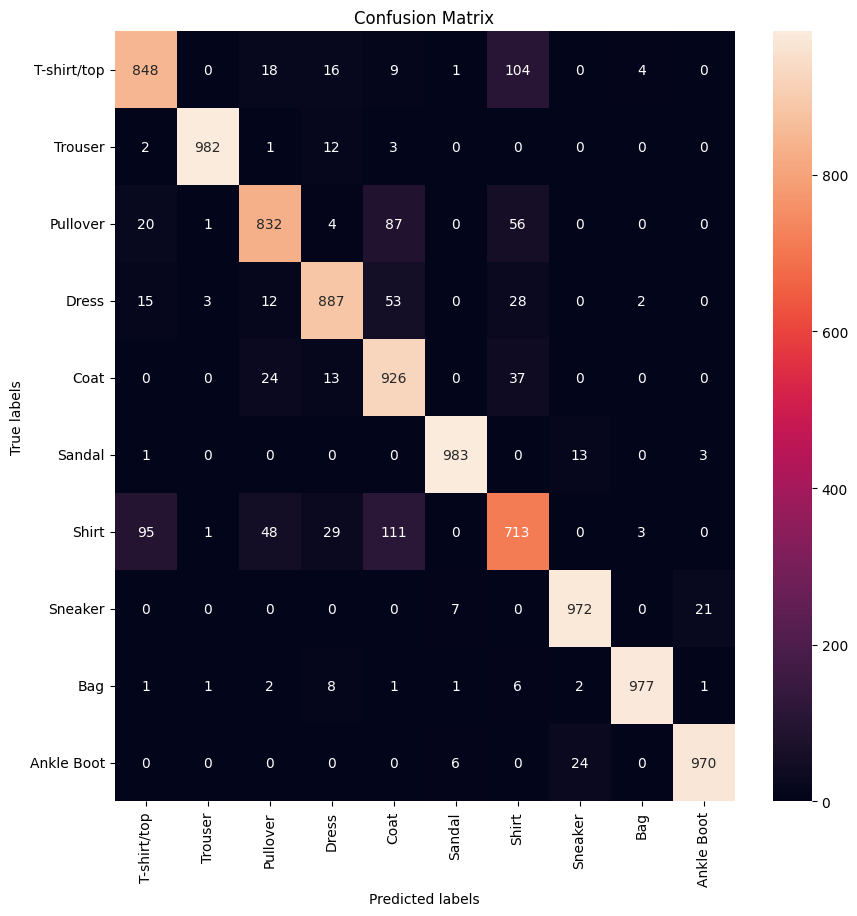

In [ ]:
#run the trainer for 12 epochs and monitor results.
trainer.run(train_loader, max_epochs=epochs)

### Plotting the loss and accuracy


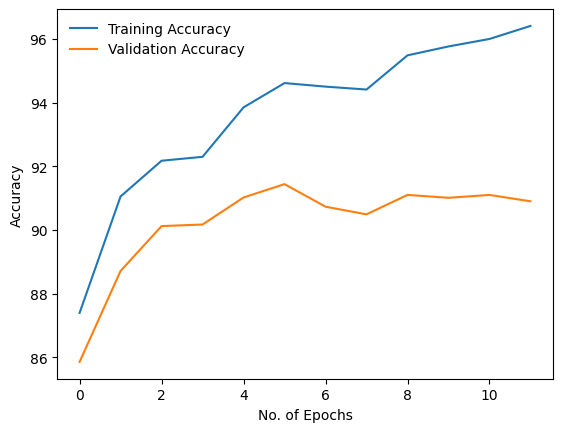

In [ ]:
#see how loss and accuracy are changing with each epoch.
plt.plot(training_history['accuracy'],label="Training Accuracy")
plt.plot(validation_history['accuracy'],label="Validation Accuracy")
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend(frameon=False)
plt.show()

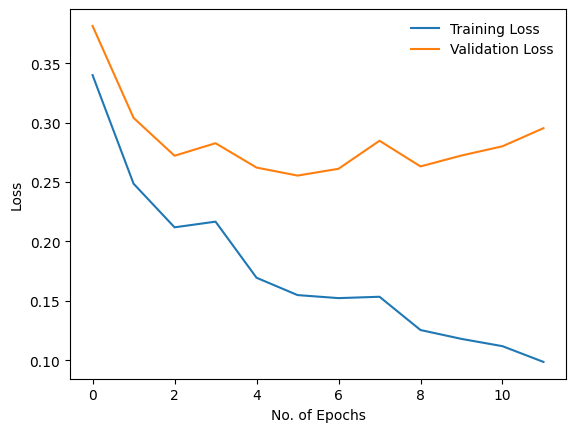

In [ ]:
plt.plot(training_history['loss'],label="Training Loss")
plt.plot(validation_history['loss'],label="Validation Loss")
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)
plt.show()

### Loading the saved model from the disk


In [ ]:
# loading the saved model from the disk for inferencing.
def fetch_last_checkpoint_model_filename(model_save_path):
    import os
    from pathlib import Path
    checkpoint_files = os.listdir(model_save_path)
    checkpoint_files = [f for f in checkpoint_files if '.pt' in f]
    checkpoint_iter = [
        int(x.split('_')[2].split('.')[0])
        for x in checkpoint_files]
    last_idx = np.array(checkpoint_iter).argmax()
    return Path(model_save_path) / checkpoint_files[last_idx]

model.load_state_dict(torch.load(fetch_last_checkpoint_model_filename('./saved_models')))
print("Model Loaded")

Model Loaded


### Inferencing the model


c:\users\jingh\appdata\local\programs\python\python38\lib\site-packages\torch\nn\functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


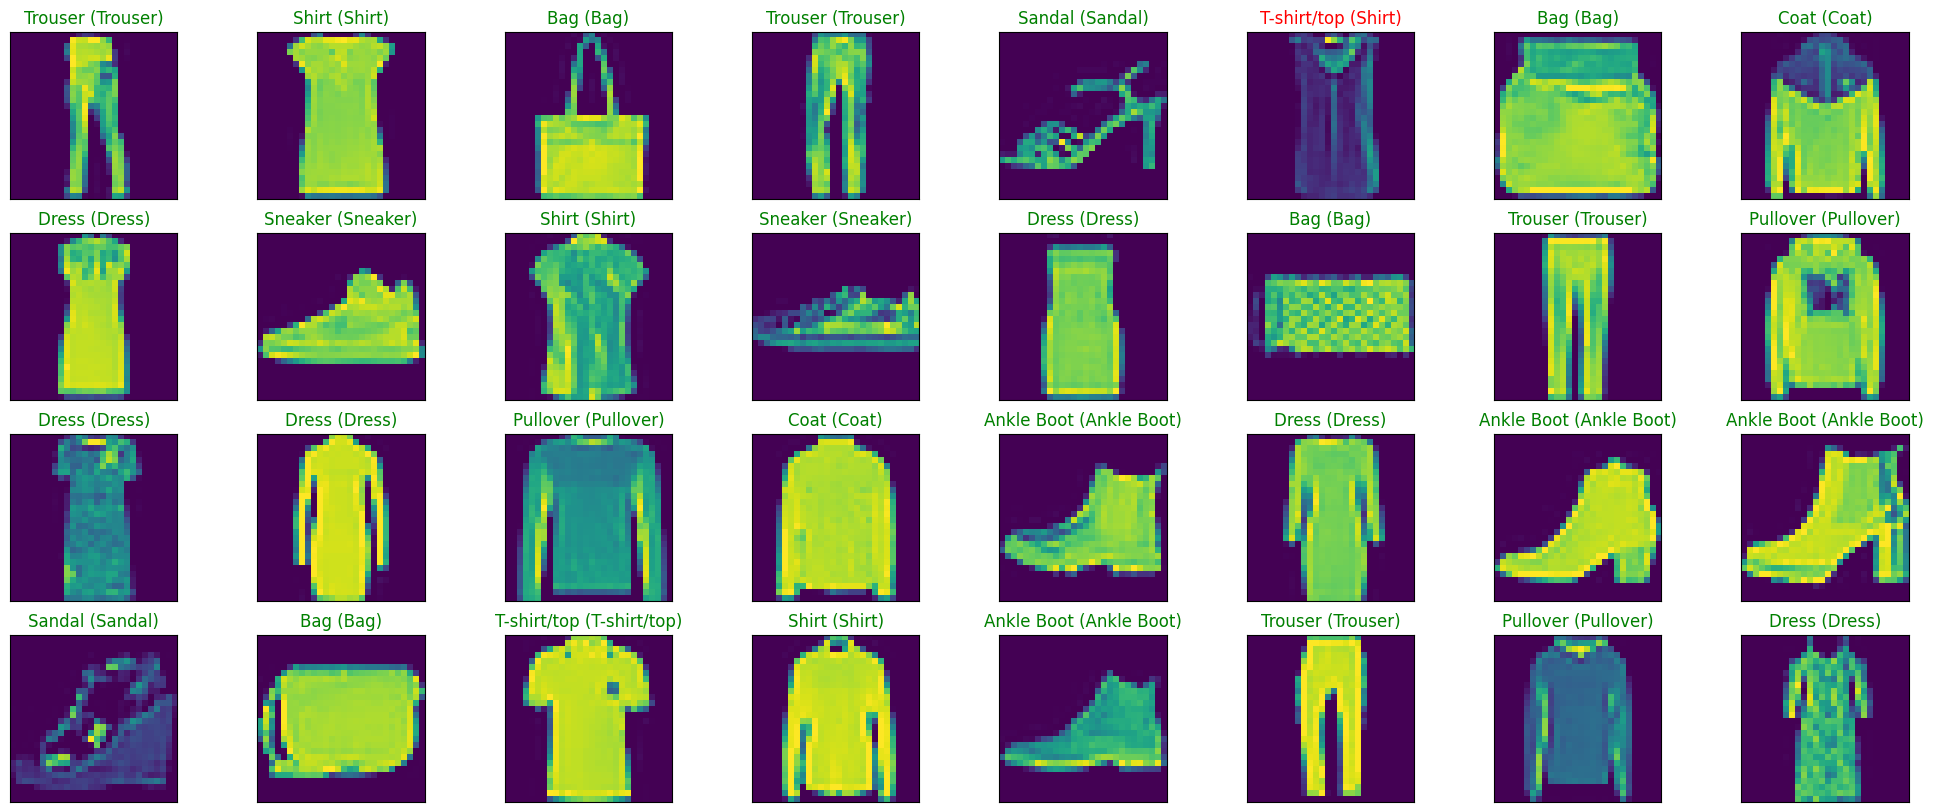

In [ ]:
# classes of fashion mnist dataset
classes = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
# creating iterator for iterating the dataset
dataiter = iter(val_loader)
images, labels = next(dataiter)
images_arr = []
labels_arr = []
pred_arr = []
# moving model to cpu for inference
model.to("cpu")
# iterating on the dataset to predict the output
for i in range(0,32):
    images_arr.append(images[i].unsqueeze(0))
    labels_arr.append(labels[i].item())
    ps = torch.exp(model(images_arr[i]))
    ps = ps.data.numpy().squeeze()
    pred_arr.append(np.argmax(ps))
# plotting the results
fig = plt.figure(figsize=(25,10))
for i in range(32):
    ax = fig.add_subplot(4, 8, i+1, xticks=[], yticks=[])
    ax.imshow(images_arr[i].resize_(1, 28, 28).numpy().squeeze())
    ax.set_title("{} ({})".format(classes[pred_arr[i]], classes[labels_arr[i]]),
                 color=("green" if pred_arr[i]==labels_arr[i] else "red"))

### Refrences
* [Fashion MNIST with Pytorch (93% Accuracy)](https://www.kaggle.com/code/pankajj/fashion-mnist-with-pytorch-93-accuracy/notebook)
* [Convolutional Neural Networks for Classifying Fashion-MNIST Dataset using Ignite](https://github.com/pytorch/ignite/blob/master/examples/notebooks/FashionMNIST.ipynb)
* [Pytorch Ignite Text CNN example notebook](https://github.com/pytorch/ignite/blob/master/examples/notebooks/TextCNN.ipynb)
* [Pytorch Ignite MNIST example](https://github.com/pytorch/ignite/blob/master/examples/mnist/mnist.py)